# Analysis of decentralised iterative auction heuristics

In [1]:
from __future__ import annotations

import os
import sys
sys.path.append(os.path.join(os.getcwd(), ".."))

import json
from typing import List

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from src.extra.io import save_plot, ImageFormat

matplotlib.rcParams['font.family'] = "monospace"
%matplotlib inline

## Heuristic grid search

In [2]:
results_filename = '../data/dia_heuristic_grid_search_paper_r_t30_s6_dt07-22_12-17-27.json'

with open(results_filename) as file:
    results_data = json.load(file)

In [3]:
heuristic_results = {}
for model_results in results_data:
    for heuristic, heuristic_result in model_results.items():
        if heuristic == 'model':
            continue
        if heuristic in heuristic_results:
            heuristic_results[heuristic].append(heuristic_result)
        else:
            heuristic_results[heuristic] = [heuristic_result]
            
print(f'Number of heuristics: {len(heuristic_results)}')

Number of heuristics: 25


In [4]:
heuristic_avg_results = []
for heuristic, results in heuristic_results.items():
    heuristic_avg_results.append([
        heuristic,
        results[0]['price change'],
        results[0]['initial price'],
        [r['social welfare'] for r in results],
        [r['social welfare percent'] for r in results],
        [r['percentage tasks allocated'] for r in results],
        [r['total revenue'] for r in results],
        [r['rounds'] for r in results],
        [r['solve time'] for r in results],
        [task_price for r in results for task_price in r['task prices'].values()],
        np.mean([r['social welfare'] for r in results]),
        np.mean([r['total revenue'] for r in results]),
        np.mean([r['rounds'] for r in results])
    ])
    
heuristic_df = pd.DataFrame(heuristic_avg_results, columns=[
    'name', 'price change', 'initial price', 'social welfare', 'social welfare percent', 
    'percentage tasks allocated', 'revenue', 'rounds', 'solve time', 'task prices',
    'avg social welfare', 'avg revenue', 'avg rounds'
])
heuristic_df = heuristic_df.sort_values(by=['price change', 'initial price'])

### General results

Text(0.5, 1.0, 'Percentage Tasks Allocated')

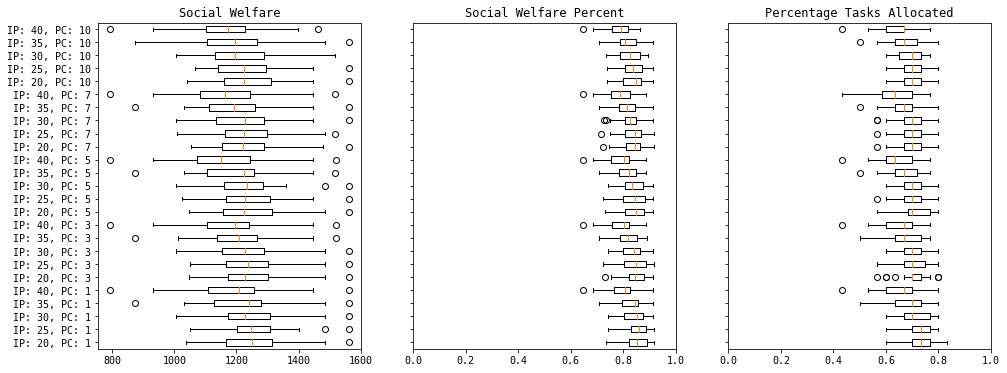

In [5]:
system_fig, (ax_sw, ax_swp, ax_pta) = plt.subplots(1, 3, figsize=(16, 6))
ax_sw.boxplot(heuristic_df['social welfare'], vert=False)
ax_sw.set_yticklabels(heuristic_df['name'])
ax_sw.set_title('Social Welfare')

ax_swp.boxplot(heuristic_df['social welfare percent'], vert=False)
plt.setp(ax_swp.get_yticklabels(), visible=False)
ax_swp.set_xticks(np.arange(0, 1.2, 0.2))
ax_swp.set_title('Social Welfare Percent')

ax_pta.boxplot(heuristic_df['percentage tasks allocated'], vert=False)
plt.setp(ax_pta.get_yticklabels(), visible=False)
ax_pta.set_xticks(np.arange(0, 1.2, 0.2))
ax_pta.set_title('Percentage Tasks Allocated')

Text(0.5, 1.0, 'Solve time')

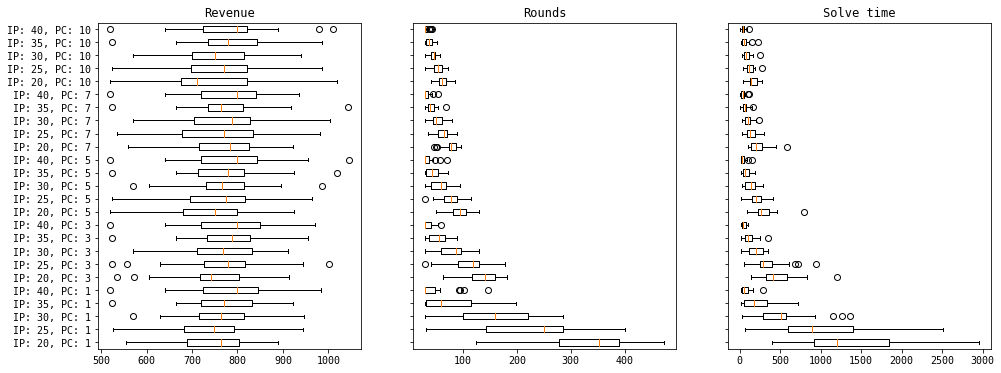

In [6]:
auction_fig, (ax_rev, ax_rounds, ax_solve_time) = plt.subplots(1, 3, figsize=(16, 6))
ax_rev.boxplot(heuristic_df['revenue'], vert=False)
ax_rev.set_yticklabels(heuristic_df['name'])
ax_rev.set_title('Revenue')

ax_rounds.boxplot(heuristic_df['rounds'], vert=False)
plt.setp(ax_rounds.get_yticklabels(), visible=False)
ax_rounds.set_title('Rounds')

ax_solve_time.boxplot(heuristic_df['solve time'], vert=False)
plt.setp(ax_solve_time.get_yticklabels(), visible=False)
ax_solve_time.set_title('Solve time')

### Grid search heatmap

In [7]:
def difference(results_1, results_2):
    sw, rev, rounds, solve_time = [], [], [], []
    for r1, r2 in zip(results_1, results_2):
        sw.append(r1['social welfare'] / r2['social welfare'])
        rev.append(r1['total revenue'] / r2['total revenue'])
        rounds.append(r1['rounds'] / r2['rounds'])
        solve_time.append(r1['solve time'] / r2['solve time'])
    return np.mean(sw), np.mean(rev), np.mean(rounds), np.mean(solve_time), sw, rev, rounds, solve_time

min_heuristic_results = heuristic_results['IP: 20, PC: 1']
heuristic_difference_results = [
    [heuristic, results[0]['price change'], results[0]['initial price'],
     *difference(results, min_heuristic_results)]
    for heuristic, results in heuristic_results.items()
]
heuristic_diff_df = pd.DataFrame(heuristic_difference_results, columns=[
    'name', 'price change', 'initial price', 
    'social welfare diff', 'revenue diff', 'rounds diff', 'solve time diff',
    'social welfare diff list', 'revenue diff list', 'rounds diff list', 'solve time diff list'
])

In [16]:
def custom_heatmap(ax, col, title, df, label_df, label_col, 
                   initial_prices=['40', '35', '30', '25', '20'], price_changes=['1', '3', '5', '7', '10']):
    ax.set_yticks(np.arange(len(price_changes)))
    ax.set_yticklabels(list(reversed(price_changes)))
    ax.set_ylabel('Price Change')
    ax.set_xticks(np.arange(len(initial_prices)))
    ax.set_xticklabels(list(reversed(initial_prices)))
    ax.set_xlabel('Initial Price')
    ax.set_title(title)
    
    heatmap = ax.imshow(df.pivot(index='price change', columns='initial price', values=col).sort_index(axis=0, ascending=False))
    print(df.pivot(index='price change', columns='initial price', values=col).sort_index(axis=0, ascending=False))
    plt.colorbar(heatmap)
    
    for x, initial_price in enumerate(initial_prices):
        for y, price_change in enumerate(price_changes):
            label = label_df[label_df['name'] == f'IP: {initial_price}, PC: {price_change}'].get(label_col).values[0]
            ax.text(len(initial_prices) - 1 - x, len(price_changes) - 1 - y, 
                    round(label), color='white', ha='center', va='center', weight='bold')

initial price        20        25        30        35        40
price change                                                   
10             0.985796  0.981687  0.968747  0.958330  0.923223
7              0.982451  0.981695  0.973124  0.953120  0.923699
5              0.990121  0.985925  0.981823  0.957004  0.925100
3              0.991906  0.990989  0.979704  0.962122  0.931088
1              1.000000  1.000343  0.987596  0.974881  0.938628
Save file location: figs/dia_heuristics/eps/social_welfare_grid.eps
Save file location: figs/dia_heuristics/png/social_welfare_grid.png
Save file location: figs/dia_heuristics/pdf/social_welfare_grid.pdf


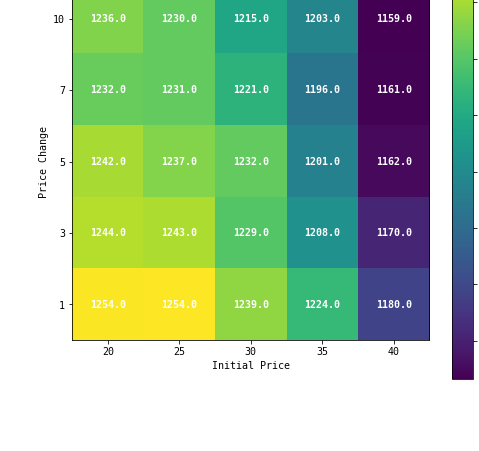

In [17]:
_, ax_gs_sw = plt.subplots(figsize=(8, 8))
custom_heatmap(ax_gs_sw, 'social welfare diff', 'Percentage difference in Social Welfare', heuristic_diff_df,
               heuristic_df, 'avg social welfare')
save_plot('social_welfare_grid', 'dia_heuristics')

initial price        20        25        30        35        40
price change                                                   
10             1.002570  1.026294  1.023377  1.057717  1.058145
7              1.019661  1.016287  1.043814  1.043516  1.057678
5              1.000186  1.021306  1.030545  1.042410  1.065070
3              1.012231  1.034691  1.033605  1.050304  1.062287
1              1.000000  1.000482  1.031232  1.040805  1.070882
Save file location: figs/dia_heuristics/eps/revenue_grid.eps
Save file location: figs/dia_heuristics/png/revenue_grid.png
Save file location: figs/dia_heuristics/pdf/revenue_grid.pdf


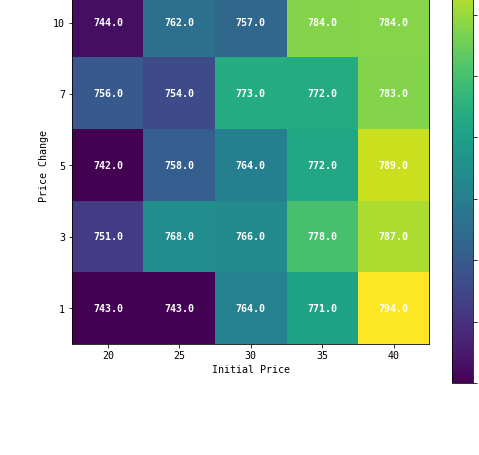

In [18]:
_, ax_gs_rev = plt.subplots(figsize=(8, 8))
custom_heatmap(ax_gs_rev, 'revenue diff', 'Percentage difference in Revenue', heuristic_diff_df,
               heuristic_df, 'avg revenue')
save_plot('revenue_grid', 'dia_heuristics')

initial price        20        25        30        35        40
price change                                                   
10             0.199843  0.169570  0.141909  0.122977  0.107311
7              0.247549  0.200334  0.163892  0.133482  0.110022
5              0.293728  0.235356  0.177103  0.139074  0.115456
3              0.426578  0.329996  0.232850  0.167445  0.117333
1              1.000000  0.677873  0.461986  0.232657  0.143183
Save file location: figs/dia_heuristics/eps/rounds_grid.eps
Save file location: figs/dia_heuristics/png/rounds_grid.png
Save file location: figs/dia_heuristics/pdf/rounds_grid.pdf


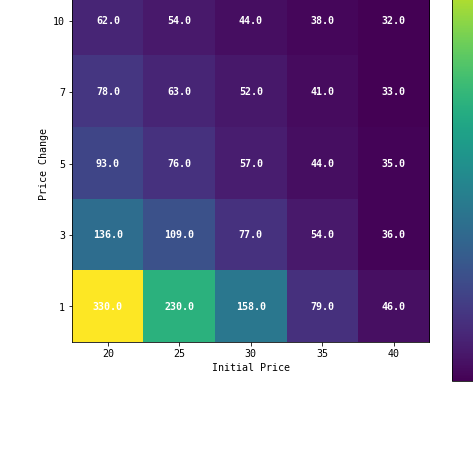

In [19]:
_, ax_gs_rounds = plt.subplots(figsize=(8, 8))
custom_heatmap(ax_gs_rounds, 'rounds diff', 'Percentage difference in Rounds', heuristic_diff_df,
               heuristic_df, 'avg rounds')
save_plot('rounds_grid', 'dia_heuristics')

### Difference in social welfare, revenue and rounds

Text(0.5, 1.0, 'Difference in Rounds')

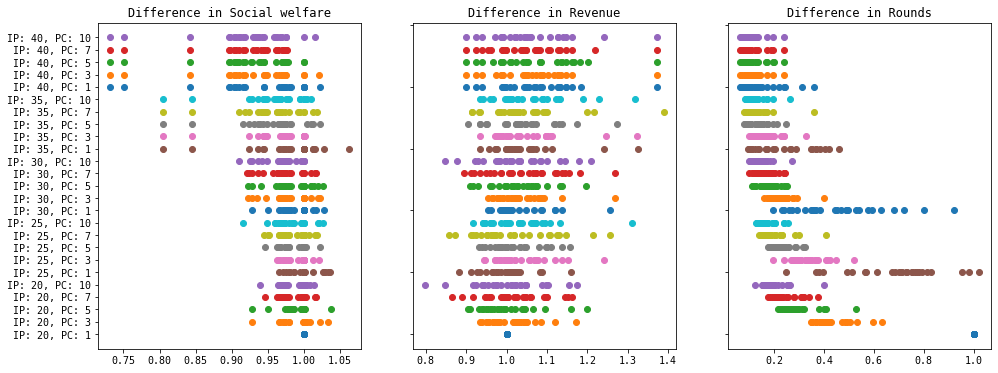

In [12]:
diff_fig, (ax_sw_diff, ax_rev_diff, ax_rounds_diff) = plt.subplots(1, 3, figsize=(16, 6))
for pos, (sw_diff, rev_diff, rounds_diff) in enumerate(heuristic_diff_df[['social welfare diff list', 
                                                                          'revenue diff list', 'rounds diff list']].values):
    ax_sw_diff.scatter(sw_diff, np.ones(len(sw_diff)) * pos)
    ax_rev_diff.scatter(rev_diff, np.ones(len(sw_diff)) * pos)
    ax_rounds_diff.scatter(rounds_diff, np.ones(len(sw_diff)) * pos)
    
ax_sw_diff.set_yticks(np.arange(len(heuristic_diff_df['name'])))
ax_sw_diff.set_yticklabels(heuristic_diff_df['name'], minor=False)
ax_sw_diff.set_title('Difference in Social welfare')

plt.setp(ax_rev_diff.get_yticklabels(), visible=False)
ax_rev_diff.set_title('Difference in Revenue')

plt.setp(ax_rounds_diff.get_yticklabels(), visible=False)
ax_rounds_diff.set_title('Difference in Rounds')

### Task Price

Text(0.5, 1.0, 'Task Price distribution')

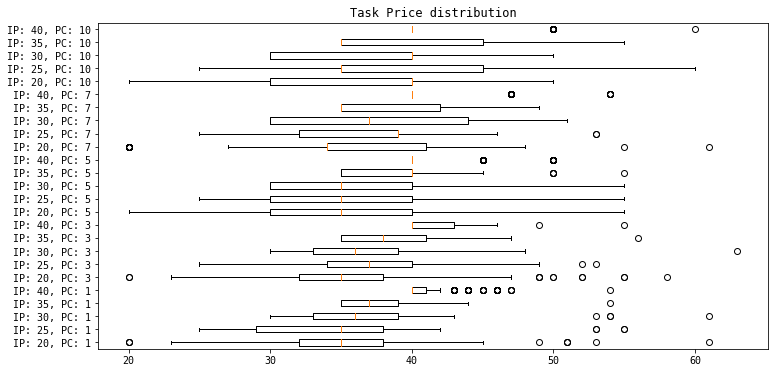

In [13]:
task_price_fig, ax_box_price = plt.subplots(figsize=(12, 6))
ax_box_price.boxplot(heuristic_df['task prices'], vert=False)
ax_box_price.set_yticklabels(heuristic_df['name'])
ax_box_price.set_title('Task Price distribution')

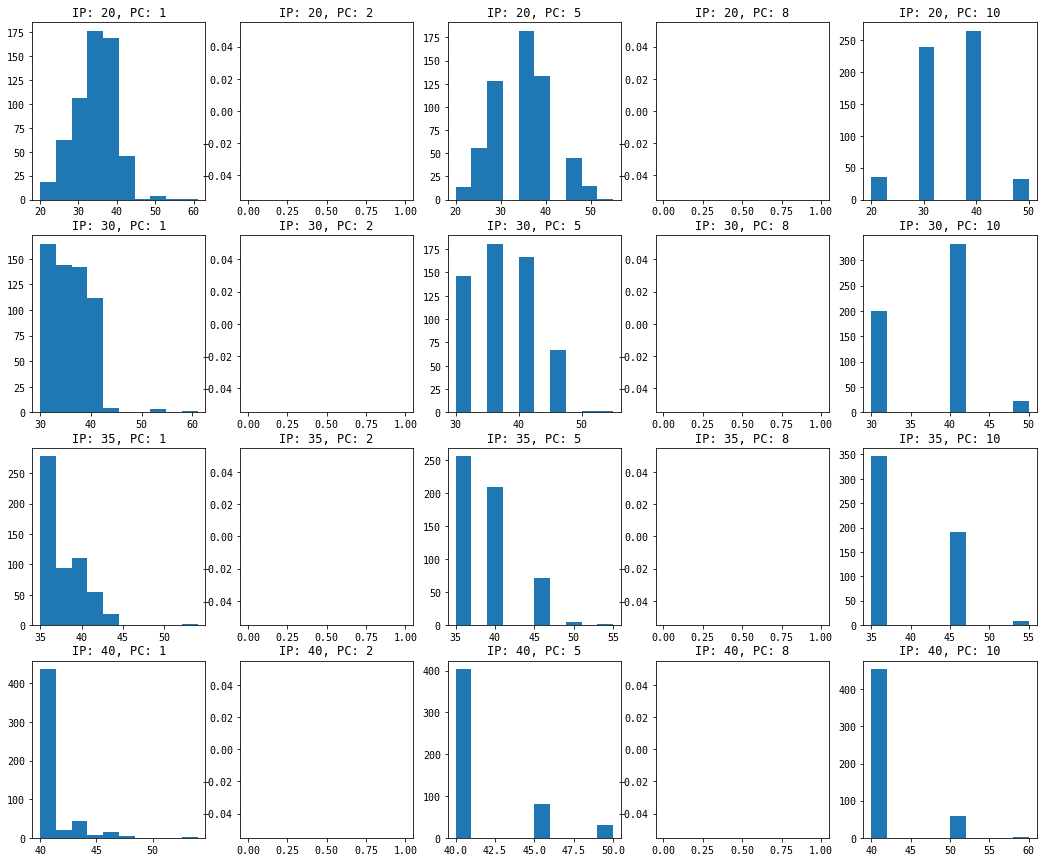

In [14]:
hist_fig, histograms = plt.subplots(4, 5, figsize=(18, 15))
for x, initial_price in enumerate(['20', '30', '35', '40']):
    for y, price_change in enumerate(['1', '2', '5', '8', '10']):
        histograms[x][y].hist(heuristic_df[heuristic_df['name'] == f'IP: {initial_price}, PC: {price_change}']['task prices'])
        histograms[x][y].set_title(f'IP: {initial_price}, PC: {price_change}')

## Non-uniform heuristics

In [15]:
results_filename = '../data/dia_non_uniform_heuristic_paper_r_t30_s6_dt07-14_15-06-16.json'

with open(results_filename) as file:
    results_data = json.load(file)

FileNotFoundError: [Errno 2] No such file or directory: '../data/dia_non_uniform_heuristic_paper_r_t30_s6_dt07-14_15-06-16.json'